# IMPORTAR DATASET

In [1]:
# Importar Librerias
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Especificar la ruta del archivo CSV en tu Google Drive
file_path = '/content/drive/MyDrive/spam.csv'

# Cargar el archivo CSV en un DataFrame de Pandas
df = pd.read_csv(file_path, encoding="latin1")

# ANALISIS EXPLORATORIO

In [5]:
# Visualizar las primeras filas del DataFrame
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [7]:
# Identificar columnas con nombre 'Unnamed'
columnas_unnamed = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

# Eliminar filas con datos en columnas 'Unnamed'
df = df.drop(df[df[columnas_unnamed].notnull().any(axis=1)].index)

# Eliminar columnas 'Unnamed'
df = df.drop(columnas_unnamed, axis=1)

# Renombrar las columnas v1 y v2 a 'Etiqueta' y 'Texto' respectivamente
df = df.rename(columns={'v1': 'Etiqueta', 'v2': 'Texto'})

In [8]:
df.head()

,Etiqueta,Texto
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5522 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Etiqueta  5522 non-null   object
 1   Texto     5522 non-null   object
dtypes: object(2)
memory usage: 129.4+ KB


In [10]:
df.shape

(5522, 2)

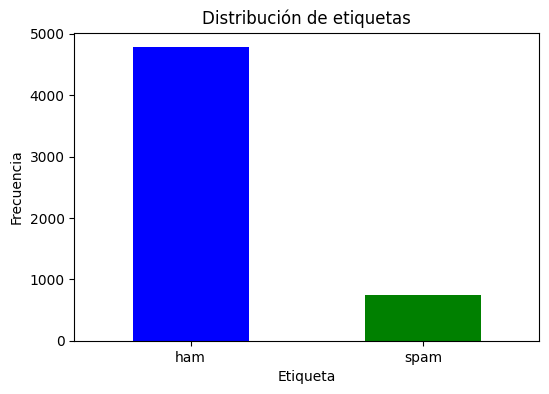

In [11]:
# Gráfico de barras para la distribución de etiquetas
plt.figure(figsize=(6, 4))
df['Etiqueta'].value_counts().plot(kind='bar', color=['blue', 'green'])
plt.title('Distribución de etiquetas')
plt.xlabel('Etiqueta')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.show()

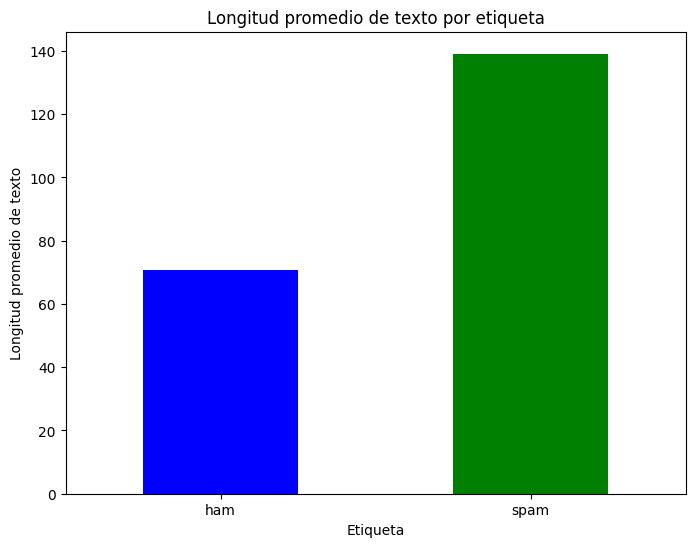

In [12]:
# Gráfico de barras apiladas de longitud de texto por etiqueta
df['Longitud_Texto'] = df['Texto'].apply(len)
plt.figure(figsize=(8, 6))
df.groupby('Etiqueta')['Longitud_Texto'].mean().plot(kind='bar', color=['blue', 'green'])
plt.title('Longitud promedio de texto por etiqueta')
plt.xlabel('Etiqueta')
plt.ylabel('Longitud promedio de texto')
plt.xticks(rotation=0)
plt.show()

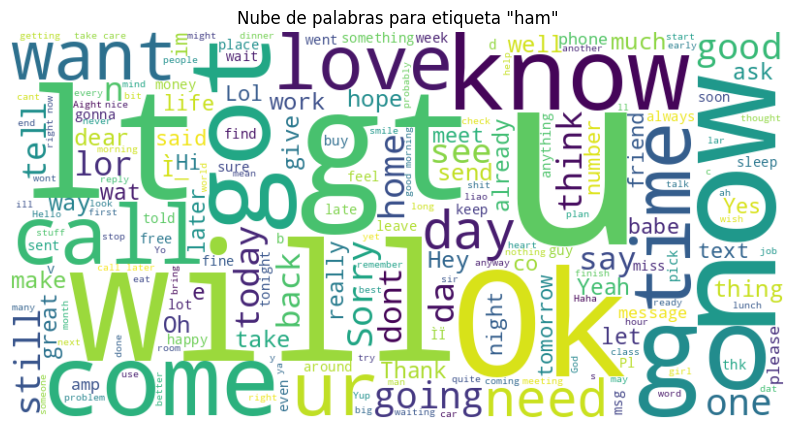

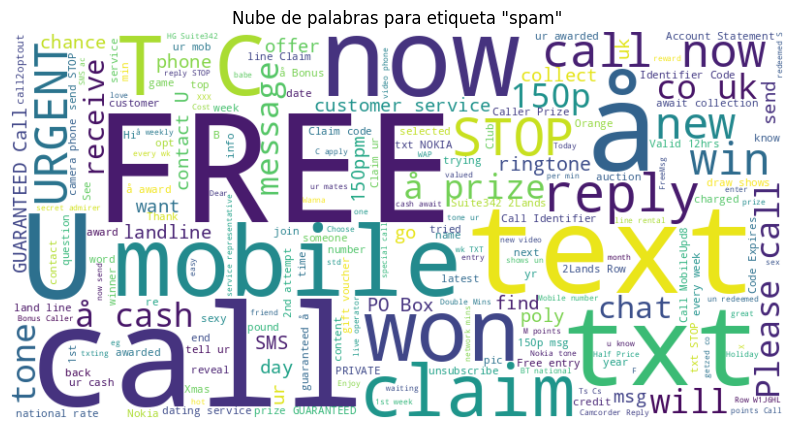

In [13]:
from wordcloud import WordCloud
# Gráfico de palabras más comunes por etiqueta (WordCloud)
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

# WordCloud para etiqueta 'ham'
ham_text = ' '.join(df[df['Etiqueta'] == 'ham']['Texto'])
generate_wordcloud(ham_text)
plt.title('Nube de palabras para etiqueta "ham"')
plt.show()

# WordCloud para etiqueta 'spam'
spam_text = ' '.join(df[df['Etiqueta'] == 'spam']['Texto'])
generate_wordcloud(spam_text)
plt.title('Nube de palabras para etiqueta "spam"')
plt.show()

# ENTRENAMIENTO DEL MODELO

In [14]:
# Mapear las etiquetas de texto a etiquetas numéricas
label_map = {"ham": 0, "spam": 1}
df["Etiqueta"] = df["Etiqueta"].map(label_map)

In [15]:
df.drop("Longitud_Texto", axis=1, inplace=True)

In [16]:
df.reset_index(drop=True, inplace=True)

In [17]:
df.head()

,Etiqueta,Texto
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [31]:
# Definir el modelo pre-entrenado de DistilBERT para clasificación de secuencias
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2).to(device)

# Cargar el tokenizer de DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenizar los mensajes y convertir las etiquetas en tensores de PyTorch
input_ids = []
attention_masks = []

for index, row in df.iterrows():
    message = row["Texto"]
    label = row["Etiqueta"]
    encoded_dict = tokenizer.encode_plus(
                        message,                      # Mensaje para tokenizar
                        add_special_tokens = True,    # Agrega tokens especiales para separar mensajes
                        max_length = 64,             # Límite máximo de tokens para DistilBERT
                        pad_to_max_length = True,    # Rellena mensajes cortos para que tengan la misma longitud
                        return_attention_mask = True, # Crea máscaras de atención para distinguir tokens reales de relleno
                        return_tensors = 'pt',       # Devuelve tensores de PyTorch
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(df["Etiqueta"])

# Divide los datos en conjuntos de entrenamiento y prueba
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.1)
train_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=42, test_size=0.1)

# Define los datasets y dataloaders de PyTorch
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=128)

validation_dataset = TensorDataset(val_inputs, val_masks, val_labels)
validation_dataloader = DataLoader(validation_dataset, sampler=SequentialSampler(validation_dataset), batch_size=128)

# Especifica los parámetros de optimización
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Listas para almacenar la pérdida durante el entrenamiento y la validación
train_loss_values = []
val_loss_values = []

# Entrena el modelo
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        optimizer.zero_grad()

        inputs = {'input_ids': batch[0].to(device),
                  'attention_mask': batch[1].to(device),
                  'labels': batch[2].to(device)}

        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    train_loss_values.append(avg_train_loss)

    # Evalúa el modelo en el conjunto de validación
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    all_predictions = []
    all_labels = []

    for batch in validation_dataloader:
        with torch.no_grad():
            inputs = {'input_ids': batch[0].to(device),
                      'attention_mask': batch[1].to(device),
                      'labels': batch[2].to(device)}

            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = batch[2].cpu().numpy()

        total_eval_accuracy += np.sum(np.argmax(logits, axis=1) == label_ids)


        # Calcular el recall
        predicted_labels = np.argmax(logits, axis=1)
        all_predictions.extend(predicted_labels)
        all_labels.extend(label_ids)

    recall = recall_score(all_labels, all_predictions)
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    val_loss_values.append(avg_val_loss)

    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Training Loss: {avg_train_loss}')
    print(f'Validation Loss: {avg_val_loss}')
    print(f'Validation Recall: {recall}')
    print(f'Validation Accuracy: {avg_val_accuracy}')
    print('------------------------------------')


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch

Epoch 1/10
Training Loss: 0.25649615100178963
Validation Loss: 0.04300743974745273
Validation Recall: 0.9342105263157895
Validation Accuracy: 109.2
------------------------------------
Epoch 2/10
Training Loss: 0.03730897121847822
Validation Loss: 0.02427311218343675
Validation Recall: 0.9342105263157895
Validation Accuracy: 109.6
------------------------------------
Epoch 3/10
Training Loss: 0.019020788395443022
Validation Loss: 0.013550281105563045
Validation Recall: 0.9736842105263158
Validation Accuracy: 109.8
------------------------------------
Epoch 4/10
Training Loss: 0.01063019370373625
Validation Loss: 0.01183477472513914
Validation Recall: 0.9736842105263158
Validation Accuracy: 110.0
------------------------------------
Epoch 5/10
Training Loss: 0.005700081183861654
Validation Loss: 0.019732430041767657
Validation Recall: 1.0
Validation Accuracy: 109.6
------------------------------------
Epoch 6/10
Training Loss: 0.0028537222891687774
Validation Loss: 0.027590566361323
Val

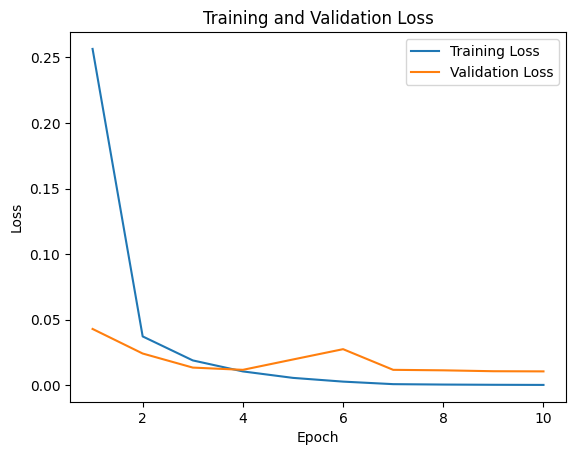

In [32]:
# Graficar la pérdida durante el entrenamiento y la validación
plt.plot(range(1, epochs + 1), train_loss_values, label='Training Loss')
plt.plot(range(1, epochs + 1), val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

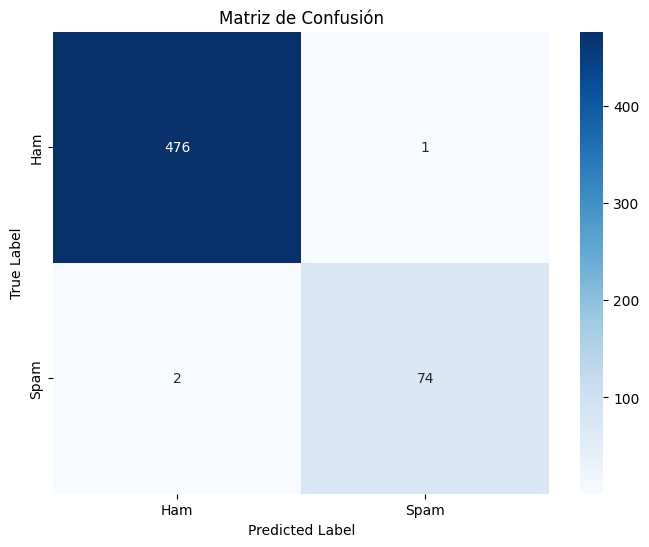

In [33]:
# Generar y mostrar la matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de Confusión')
plt.show()

# PRUEBA DEL MODELO

In [34]:
# Función para clasificar un mensaje
def classify_message(message):
    # Tokenizar el mensaje
    inputs = tokenizer.encode_plus(
        message,
        add_special_tokens=True,
        max_length=64,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Mover los datos al dispositivo
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Pasar el mensaje a través del modelo
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Obtener la etiqueta predicha
    predicted_label = torch.argmax(logits, dim=1).item()

    # Convertir la etiqueta numérica en la etiqueta de texto original
    label_map = {0: "ham", 1: "spam"}
    predicted_label_text = label_map[predicted_label]

    return predicted_label_text


In [35]:
# Ejemplo de mensaje spam
message_to_classify = "Hey! You've won a free vacation. Click here to claim your prize!"

# Clasificar el mensaje
predicted_label = classify_message(message_to_classify)
print("Predicted label:", predicted_label)

Predicted label: spam


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [36]:
# Ejemplo de mensaje legítimo
message_to_classify = "I love u!"

# Clasificar el mensaje
predicted_label = classify_message(message_to_classify)
print("Predicted label:", predicted_label)

Predicted label: ham
